## Analyzing Simulated Data

In [6]:
dfResults <- data.frame(read_length = rep(c(50,100,150), 3), method = rep(c("Bowtie2", "Chromap", "Piscem"), each = 3), accuracy = rep(0,9))

### Loading the results for Bowtie2

In [7]:
bowtie_sim_path <- "/fs/cbcb-scratch/npsingh/simulated_data/bowtie2/map/hg38"
fnames <- sapply(c(50,100,150), function(r_len) file.path(bowtie_sim_path, paste0("eval_nfrag=1000000_length=", r_len,"_er=0.25.out")))
for(i in seq_along(fnames)) {
    dfResults[i,3] <- round(read.csv(fnames[i],sep=",",header=F)[1,2],4)
}

### Loading results for Chromap

In [8]:
bowtie_sim_path <- "/fs/cbcb-scratch/npsingh/simulated_data/chromap/map/hg38_k=17_w=7/"
fnames <- sapply(c(50,100,150), function(r_len) file.path(bowtie_sim_path, paste0("eval_nfrag=1000000_length=", r_len,"_er=0.25.out")))
for(i in seq_along(fnames)) {
    dfResults[3+i,3] <- round(read.csv(fnames[i],sep=",",header=F)[1,2],4)
}

### Loading the results for simulation for piscem

In [9]:
sim_data_path <- "/fs/cbcb-scratch/npsingh/simulated_data/piscem/map/hg38"
lengths <- c("50","100","150")
m <- as.character(c(17))
kmers <- as.character(c(23,25,27,29))
bins <- c("1000","10000", "100000", "1000000", "use_chr")
thr <- as.character(c(0.6, 0.7, 0.8, 1))
orphans <- c("false")

In [5]:
## Given length 
### 1) Fix k and thr
### vary bins

### 2) Fix k and bins
### vary thrs

### 3) Fix bins and thr
#### vary k

In [10]:
map_out <- vector(mode="list", length(lengths))
names(map_out) <- paste0("Length", lengths)
for(i in seq_along(lengths)) {
    map_out[[i]] <- vector(mode="list", length(kmers))
    names(map_out[[i]]) <- paste0("k", kmers)
    for(j in seq_along(kmers)) {
        map_out[[i]][[j]] <- vector(mode="list", length(bins))
        names(map_out[[i]][[j]]) <- paste0("bin", bins)
        # names(map_out[[i]][[j]]) <- bins
        names(map_out[[i]][[j]])[length(bins)] = "binchr"
        
        for(b in seq_along(bins)) {
            map_out[[i]][[j]][[b]] <- rep(0, length(thr))
            names(map_out[[i]][[j]][[b]]) <- paste0("thr", thr)
            for(tt in thr) {
                lname <- paste("length", lengths[i], sep="=")
                kmname <- paste(paste0("k",kmers[j]), paste0("m",m), sep="_")
                bname <- paste0("bin", bins[b])
                thrname <- paste0("map_nfrag=1000000_er=0.25_thr=", tt, "_orphans=", "false")
                fname <- file.path(sim_data_path, lname, kmname, bname, thrname, "eval.out")
                pthr <- paste0("thr",tt)
                dd <- read.csv(fname,sep=",",header=F)
                map_out[[i]][[j]][[b]][pthr] <- round(read.csv(fname,sep=",",header=F)[1,2],4)
            }
        }
    }
}

In [26]:
library(data.table)
dfL <- rbind(rbindlist(map_out[[1]], fill=TRUE), rbindlist(map_out[[2]], fill=TRUE), rbindlist(map_out[[3]], fill=TRUE))
dfL[["read_length"]] <- rep(c(50,100,150), each=length(thr)*length(kmers))
dfL[["threshold"]] <- rep(thr, dim(dfL)[1]/length(thr))
dfL[["k"]] <- rep(rep(kmers, each = length(thr)),3)

In [27]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggpubr))
library(latex2exp)

In [28]:
dfL <- dfL %>% pivot_longer(cols = starts_with("bin"), 
                     names_to = "bin_size", 
                     values_to = "accuracy")
head(dfL)

read_length,threshold,k,bin_size,accuracy
<dbl>,<chr>,<chr>,<chr>,<dbl>
50,0.6,23,bin1000,93.5187
50,0.6,23,bin10000,93.2948
50,0.6,23,bin100000,92.9804
50,0.6,23,bin1000000,92.4363
50,0.6,23,binchr,82.7218
50,0.7,23,bin1000,93.5080


#### Varying K and Threshold

In [54]:
options(repr.plot.width=14, repr.plot.height=11)
size <- 20
pKThr <- vector(mode="list", length(kmers))
names(pKThr) <- paste("k",kmers,sep="")
for(i in seq_along(kmers)) {
    pKThr[[i]] <- vector(mode="list", length(thr))
    names(pKThr[[i]]) <- paste("thr", thr, sep="")
    for(j in seq_along(thr)) {
        pKThr[[i]][[j]] <- dfL %>%
            filter(k==kmers[i], threshold==thr[j]) %>%
            ggplot(aes(x=bin_size,y=accuracy, group=read_length)) + 
            geom_point(size=3,aes(color=factor(read_length))) +
            geom_line(size=1, aes(color=factor(read_length), linetype=factor(read_length))) +
            
            theme_bw() + scale_x_discrete(labels = c("1000", "10000", "100000", "1000000", "chr")) +
            labs(title = TeX(paste0("k = ", kmers[i], ", $\\tau =$", thr[j])),
                    x = TeX("$l_{vcol}$"), y = "Accuracy", color = "Read Length", linetype = "Read Length") +
              theme(
                plot.title = element_text(size = size),           # Title font size
                axis.title.x = element_text(size = size),         # X-axis label font size
                axis.title.y = element_text(size = size),         # Y-axis label font size
                axis.text = element_text(size = size),            # Tick mark font size
                legend.title = element_text(size = size),         # Legend title font size
                legend.text = element_text(size = size)           # Legend text font size
              )
    }
}        

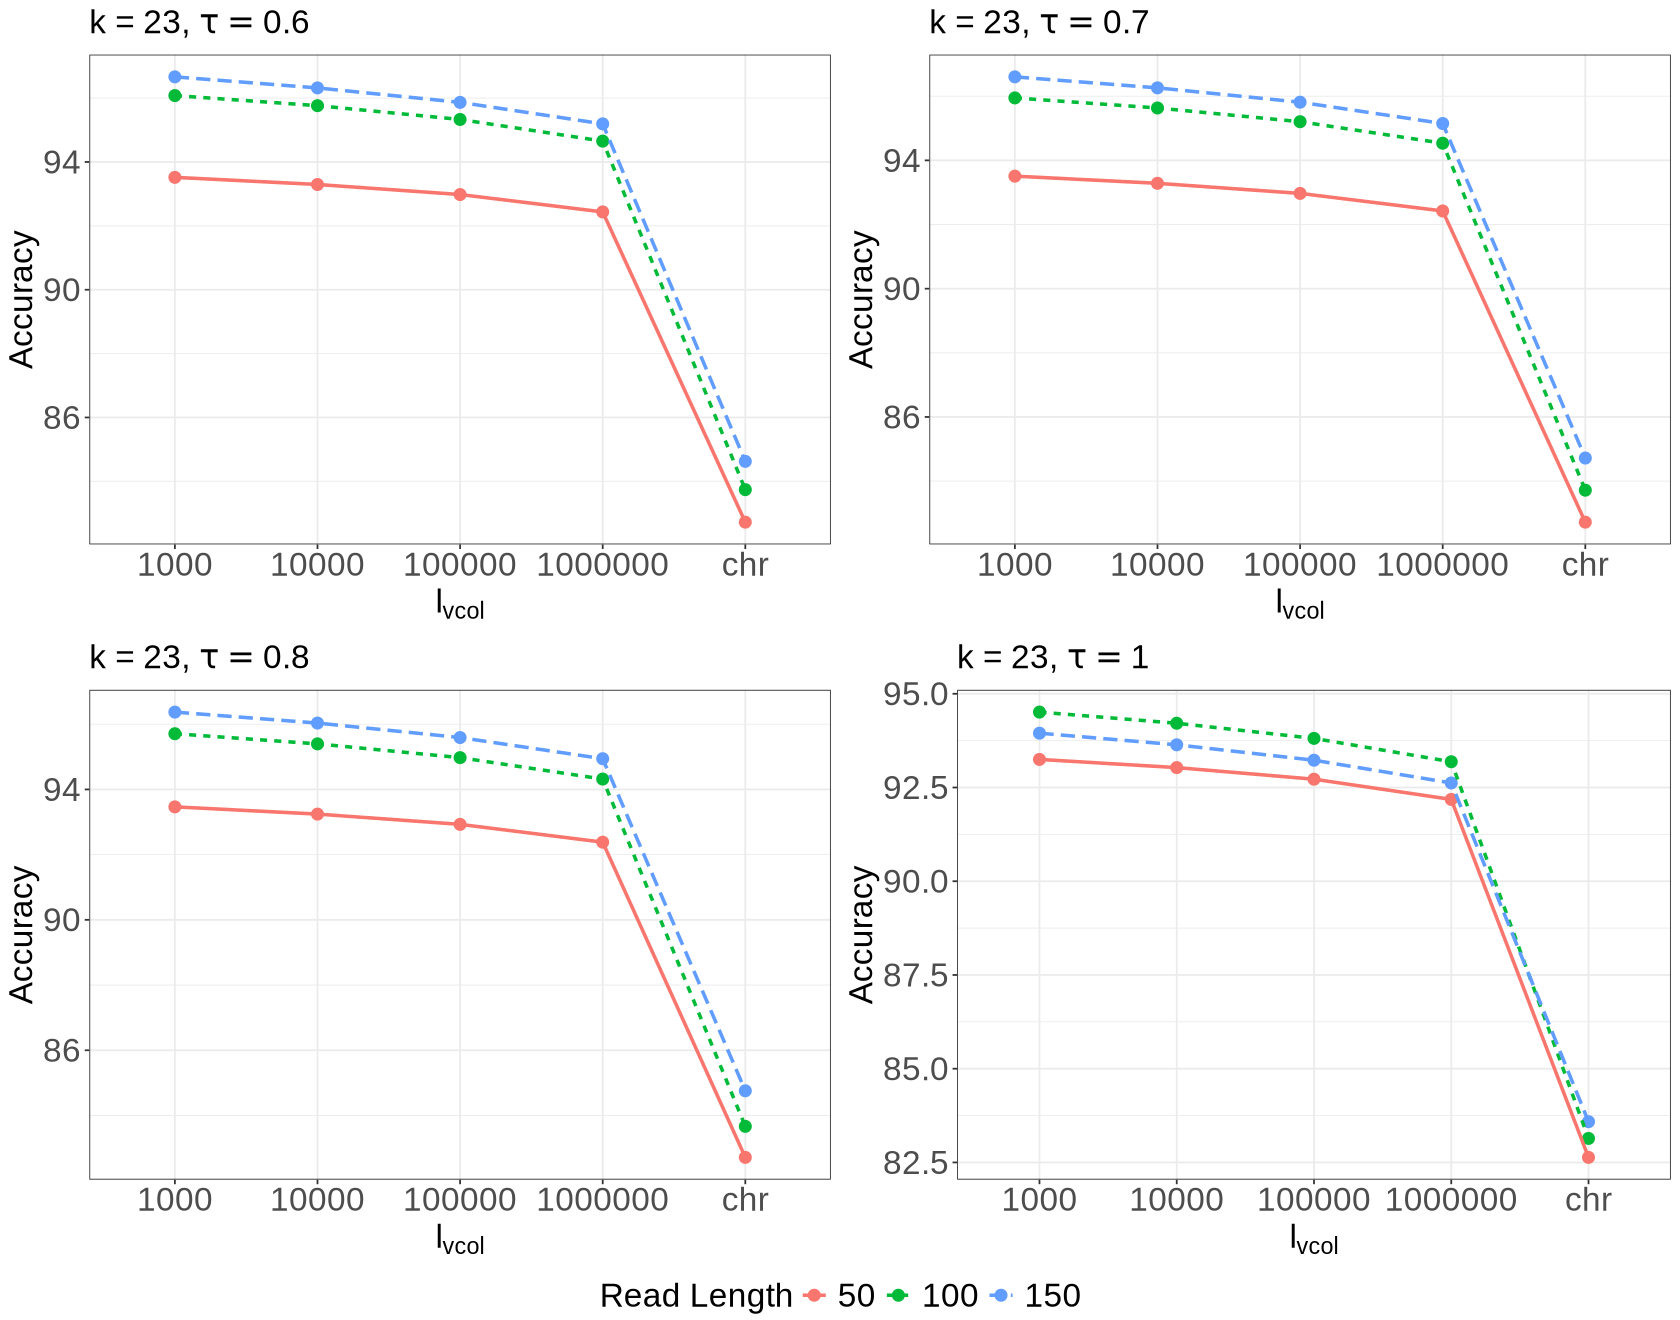

In [55]:
ggarrange(plotlist = pKThr[[1]], common.legend = TRUE, legend = "bottom")

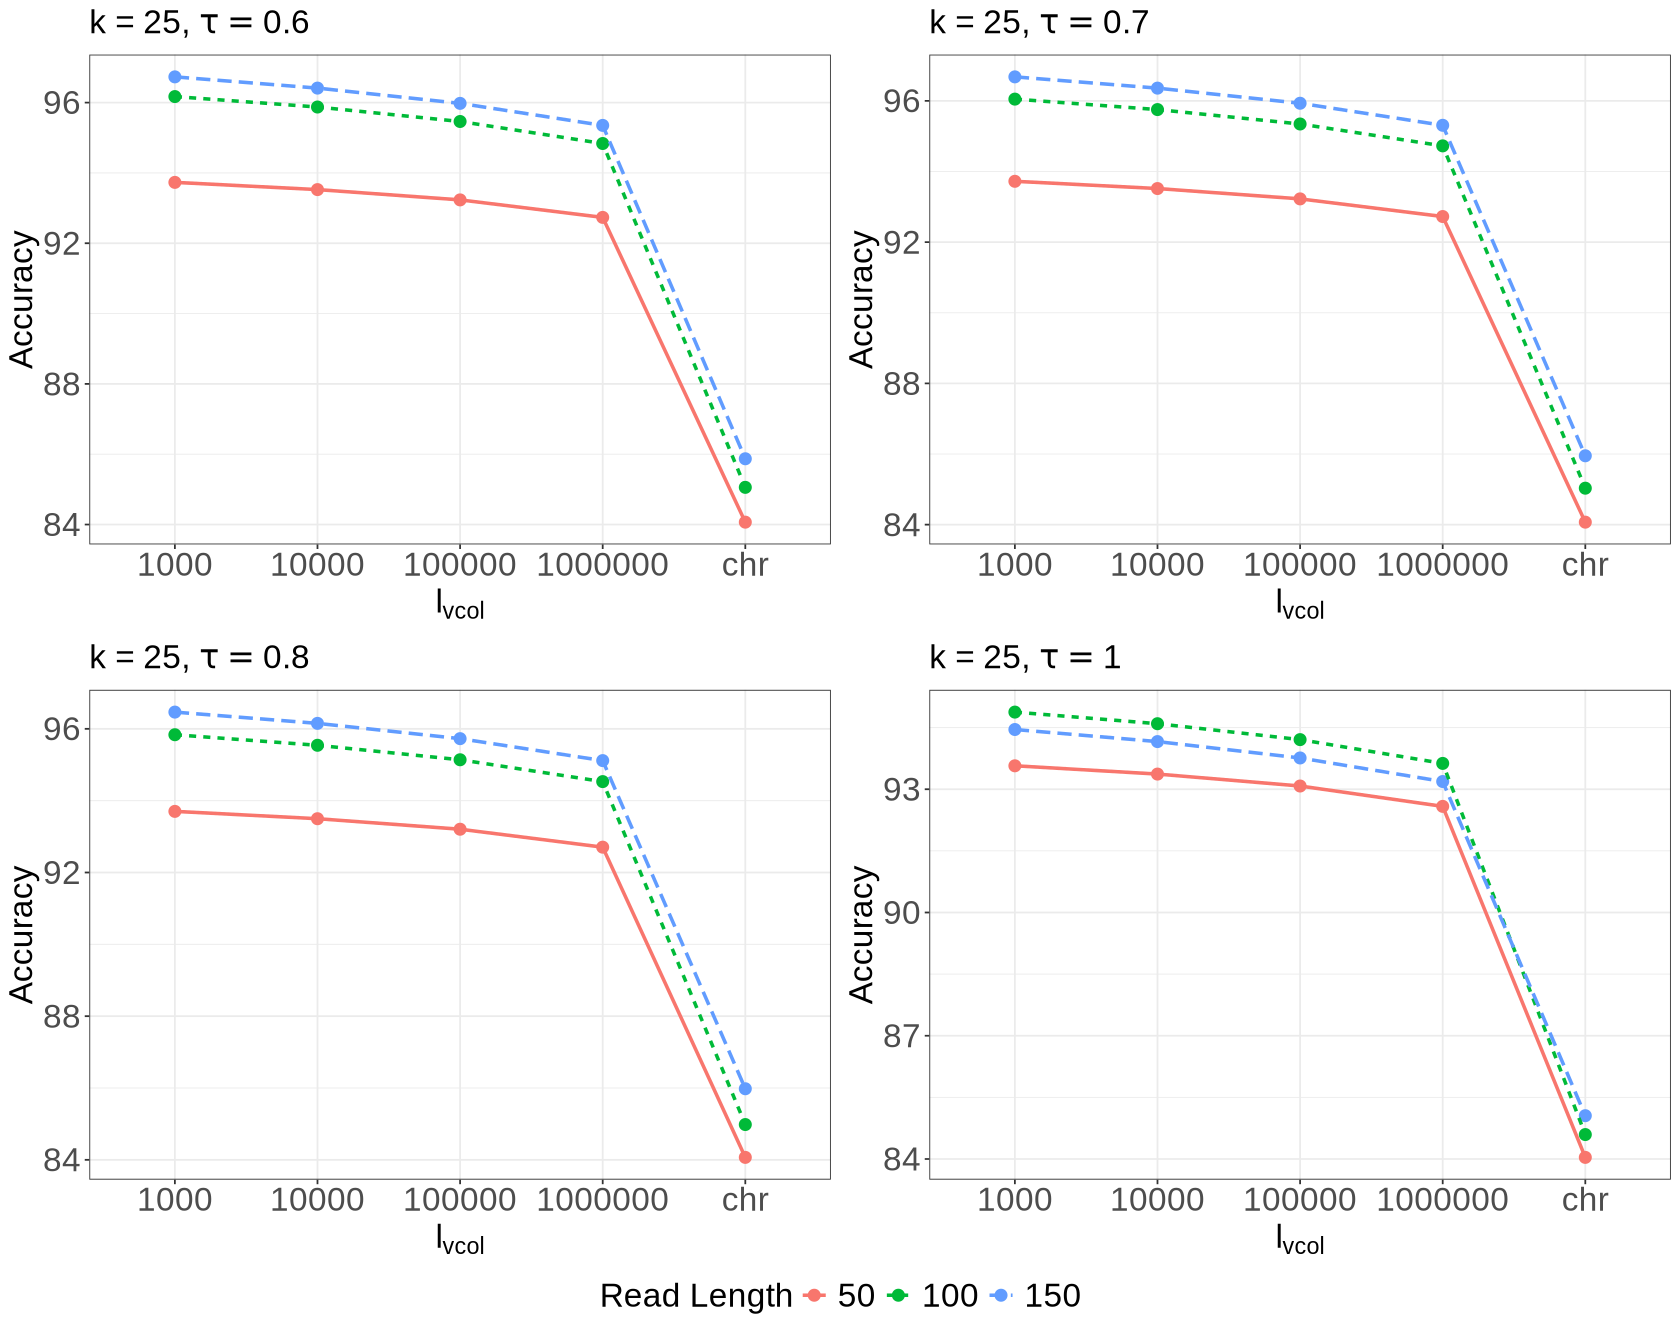

In [56]:
ggarrange(plotlist = pKThr[[2]], common.legend = TRUE, legend = "bottom")

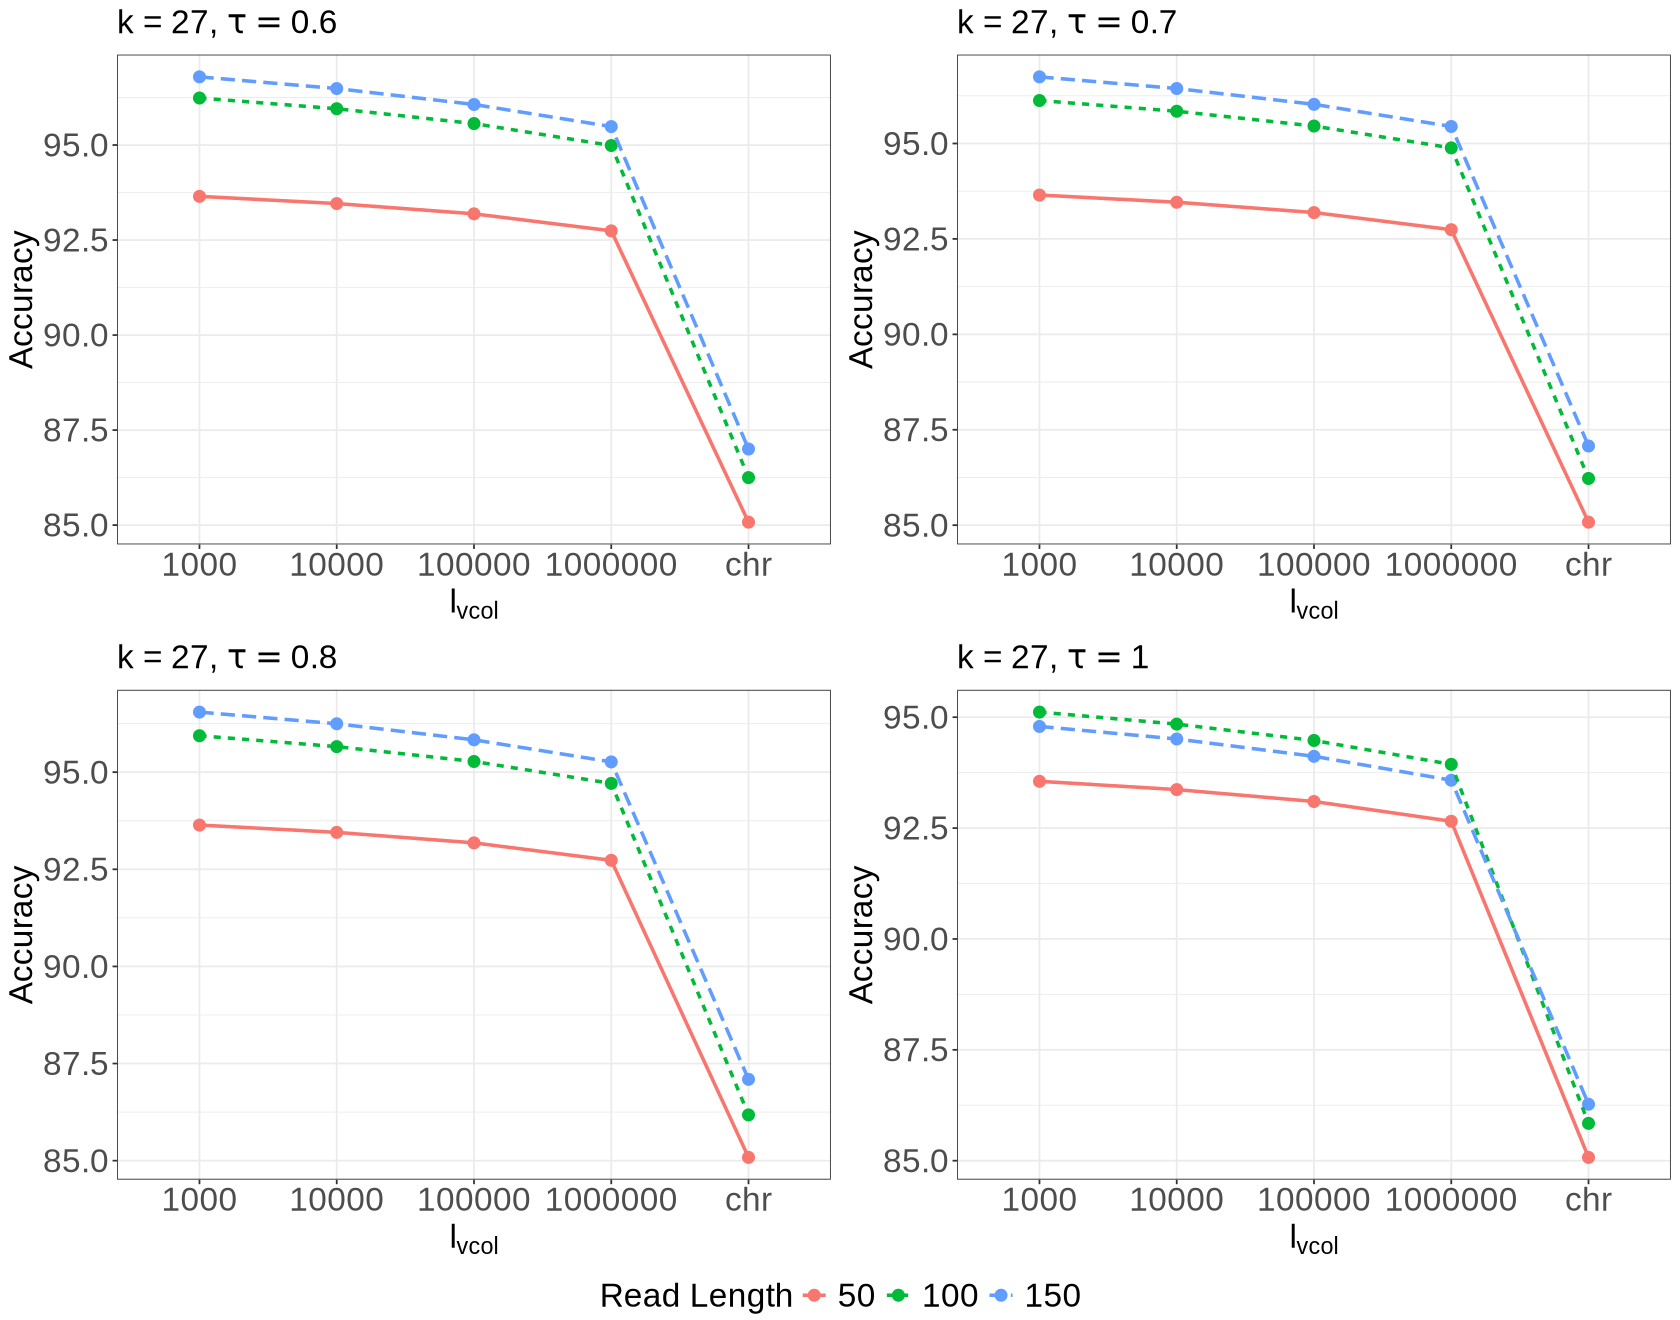

In [57]:
ggarrange(plotlist = pKThr[[3]], common.legend = TRUE, legend = "bottom")

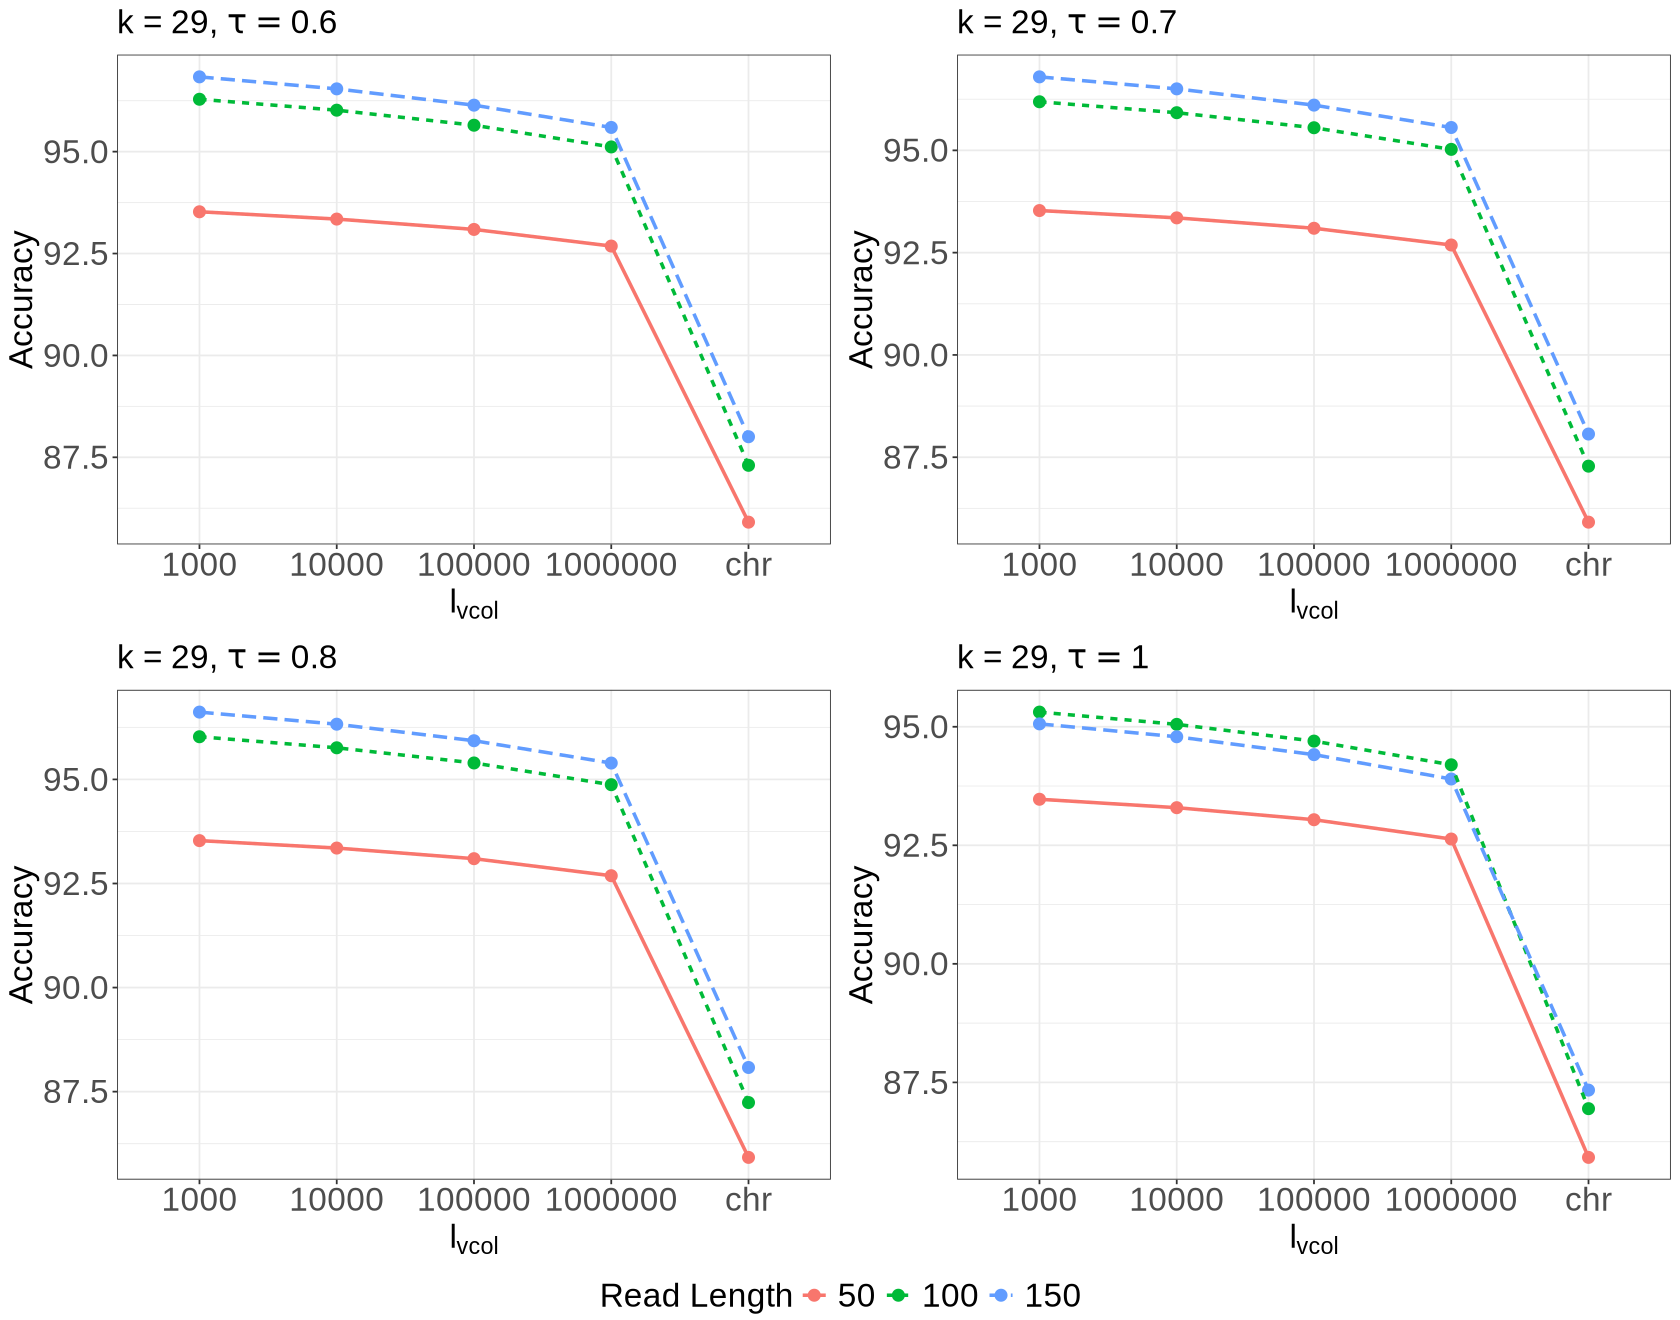

In [58]:
ggarrange(plotlist = pKThr[[4]], common.legend = TRUE, legend = "bottom")

#### Varying K and Bin Size

In [49]:
options(repr.plot.width=14, repr.plot.height=11)
size <- 20
pKBin <- vector(mode="list", length(kmers))
names(pKBin) <- paste("k",kmers,sep="")
for(i in seq_along(kmers)) {
    pKBin[[i]] <- vector(mode="list", length(bins))
    names(pKBin[[i]]) <- paste("bin", bins, sep="")
    for(j in seq_along(bins)) {
        
        dTemp <- dfL %>% 
            filter(k==kmers[i], bin_size==paste0("bin",bins[j]))
        if (j==5) {
           dTemp <- dfL %>%
            filter(k==kmers[i], bin_size=="binchr")
         }
        bb <- ifelse(j<=4, bins[j], "chr")
        
        pKBin[[i]][[j]] <- 
            dTemp %>%
            ggplot(aes(x=threshold,y=accuracy, group=read_length)) + 
            geom_point(size=3,aes(color=factor(read_length))) +
            geom_line(size=1, aes(color=factor(read_length), linetype=factor(read_length))) +
            theme_bw() +
            labs(title = TeX(paste0("k = ", kmers[i], ", $l_{vcol}$ = ", bb)), 
                    x = TeX("$\\tau$"), y = "Accuracy", color = "Read Length", linetype = "Read Length") +
              theme(
                plot.title = element_text(size = size),           # Title font size
                axis.title.x = element_text(size = size),         # X-axis label font size
                axis.title.y = element_text(size = size),         # Y-axis label font size
                axis.text = element_text(size = size),            # Tick mark font size
                legend.title = element_text(size = size),         # Legend title font size
                legend.text = element_text(size = size)           # Legend text font size
              )
    }
}        

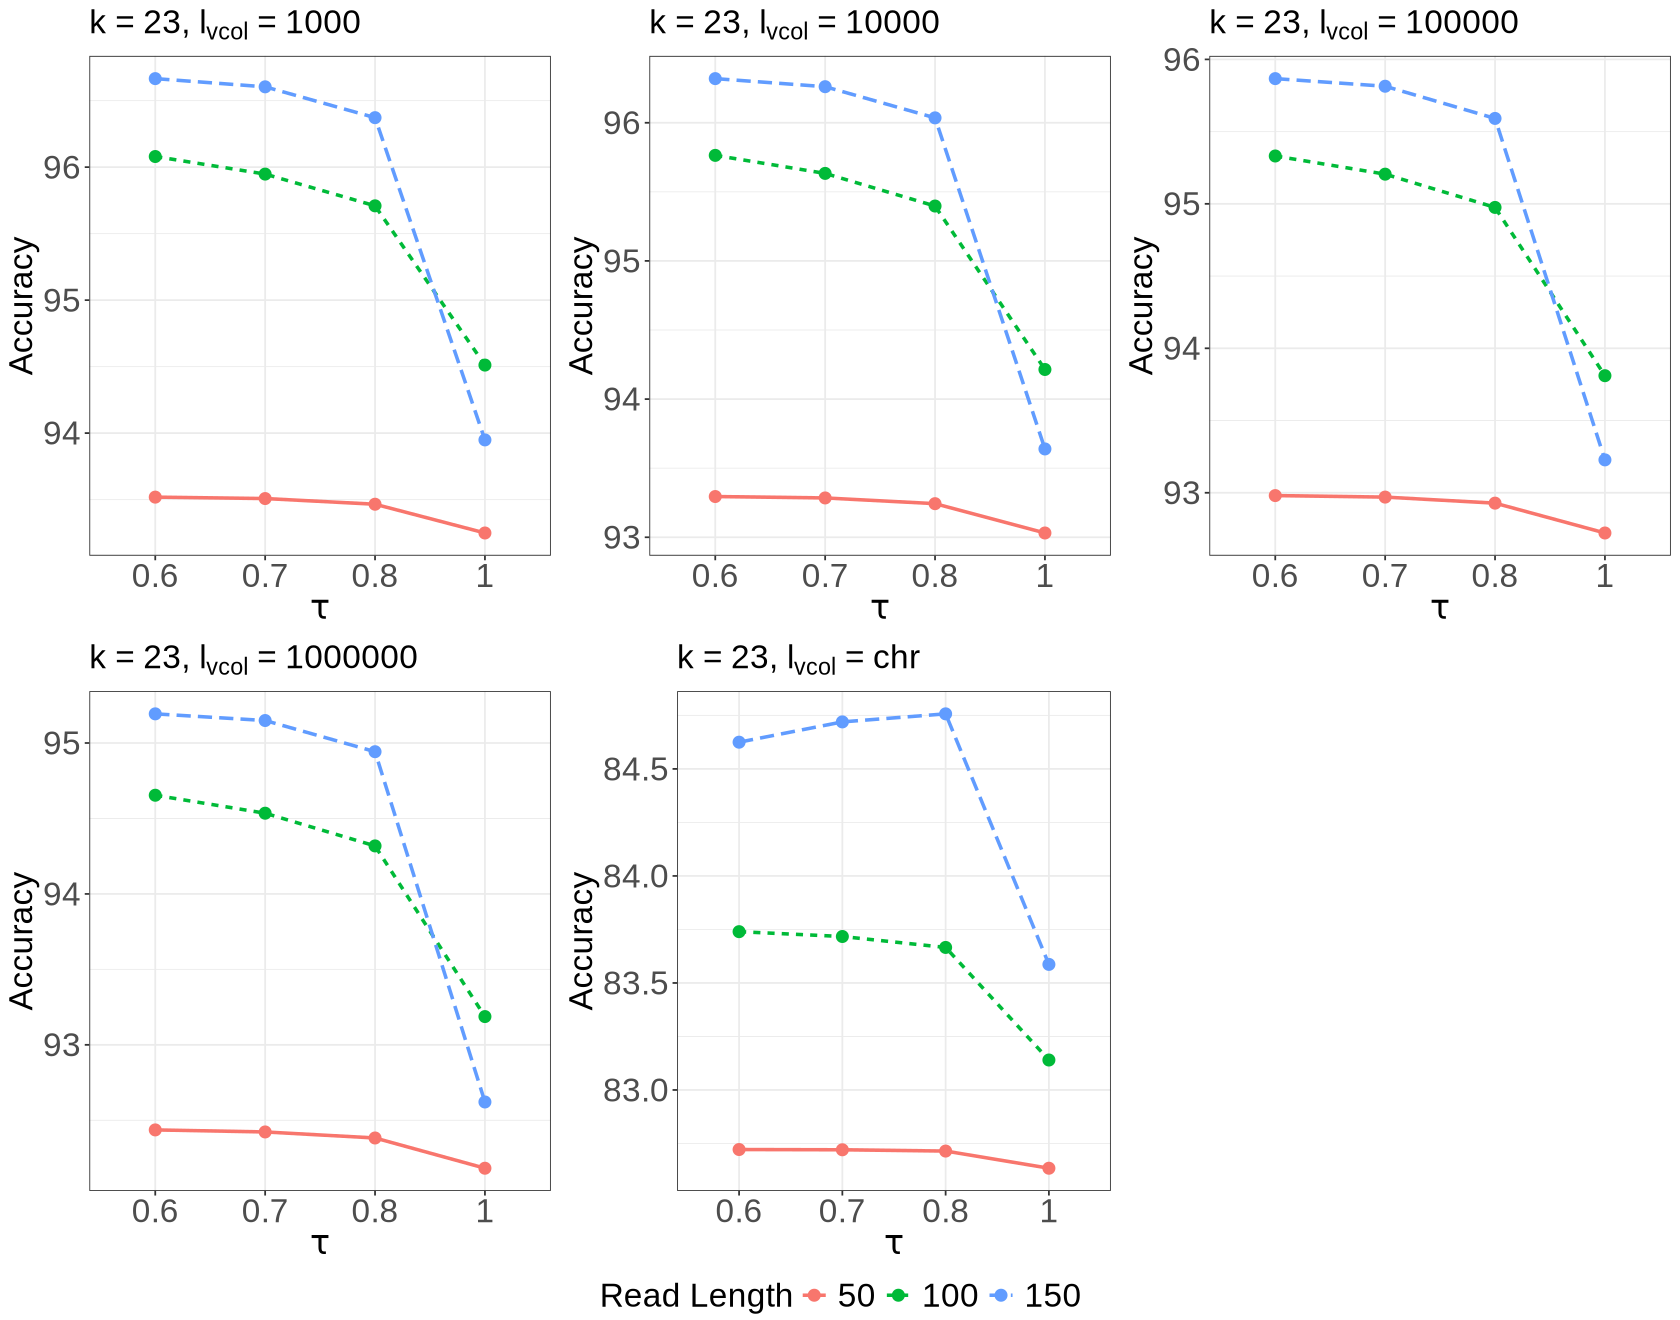

In [50]:
ggarrange(plotlist = pKBin[[1]], common.legend = TRUE, legend = "bottom")

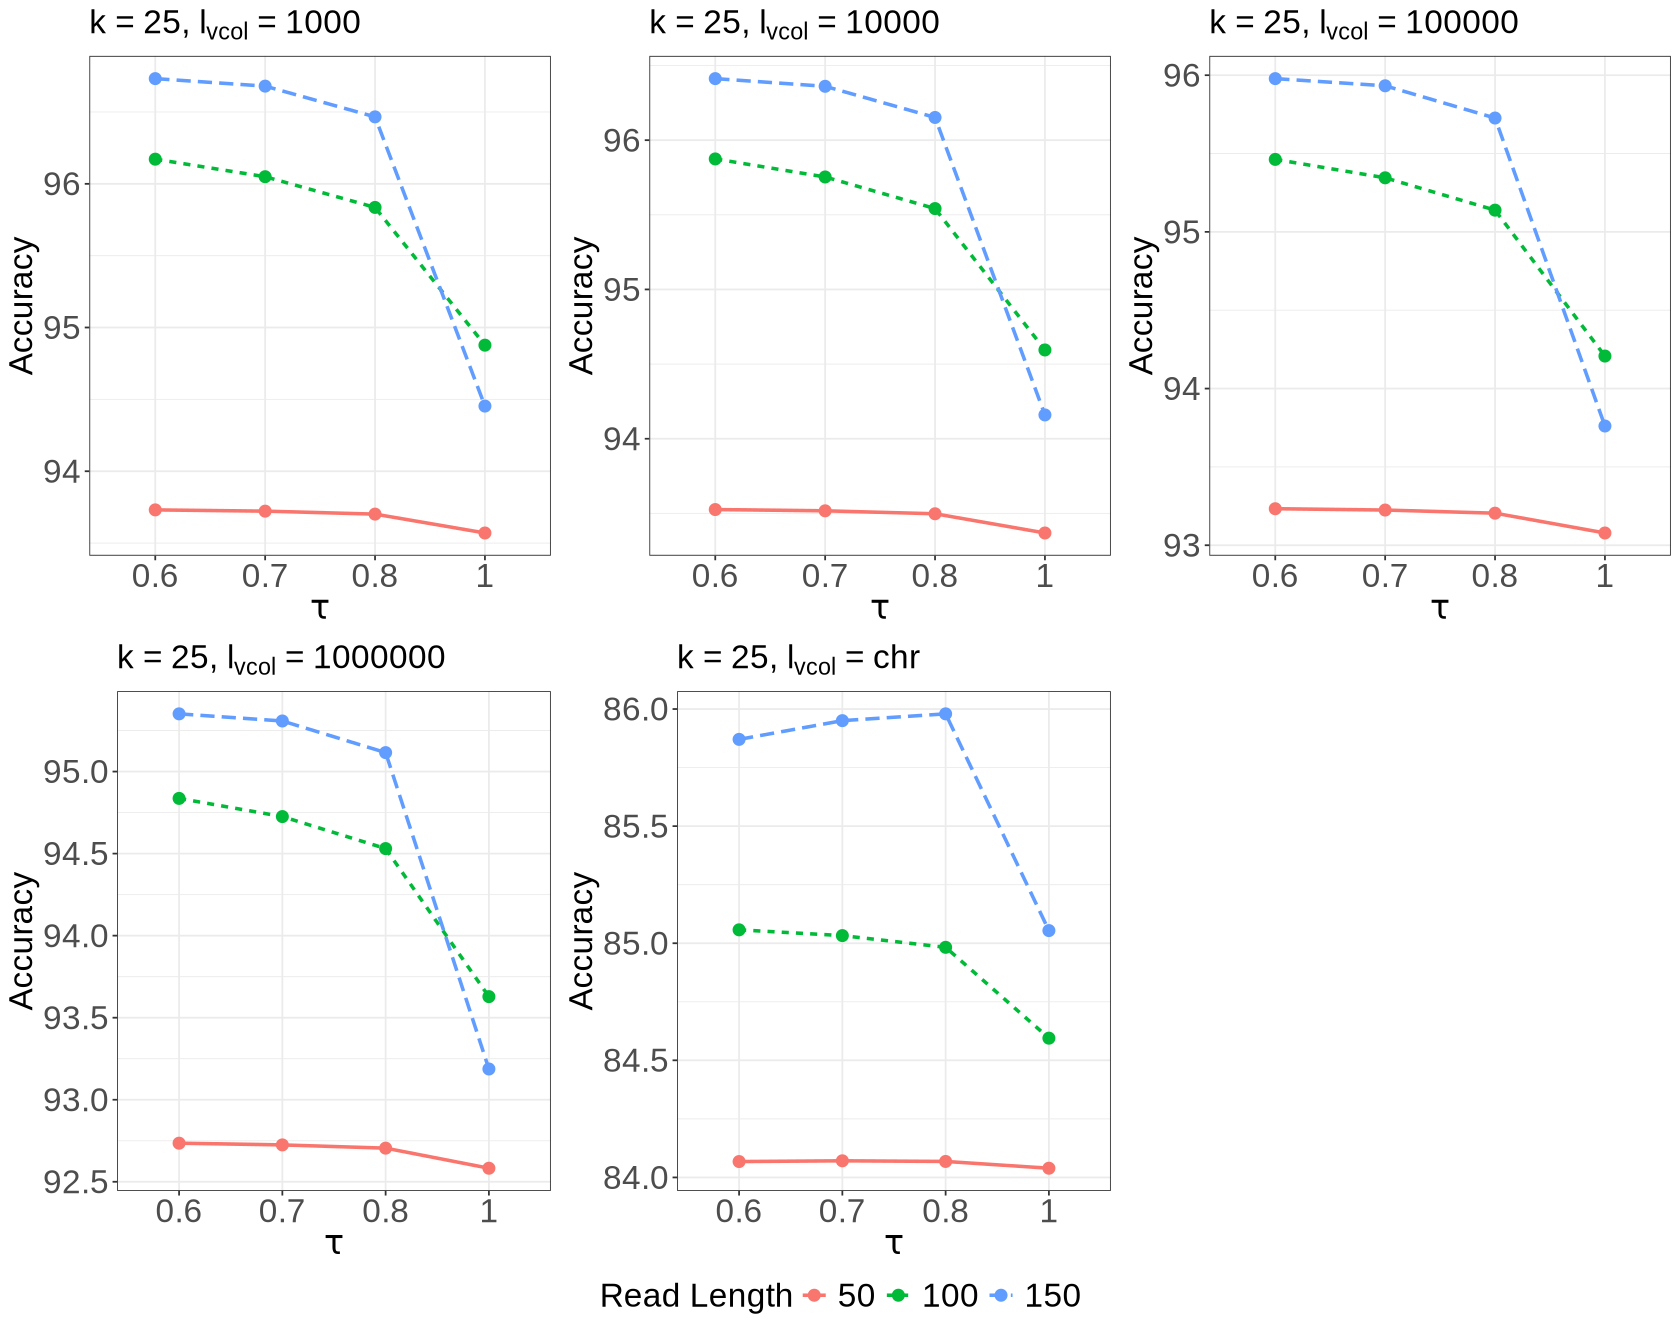

In [51]:
ggarrange(plotlist = pKBin[[2]], common.legend = TRUE, legend = "bottom")

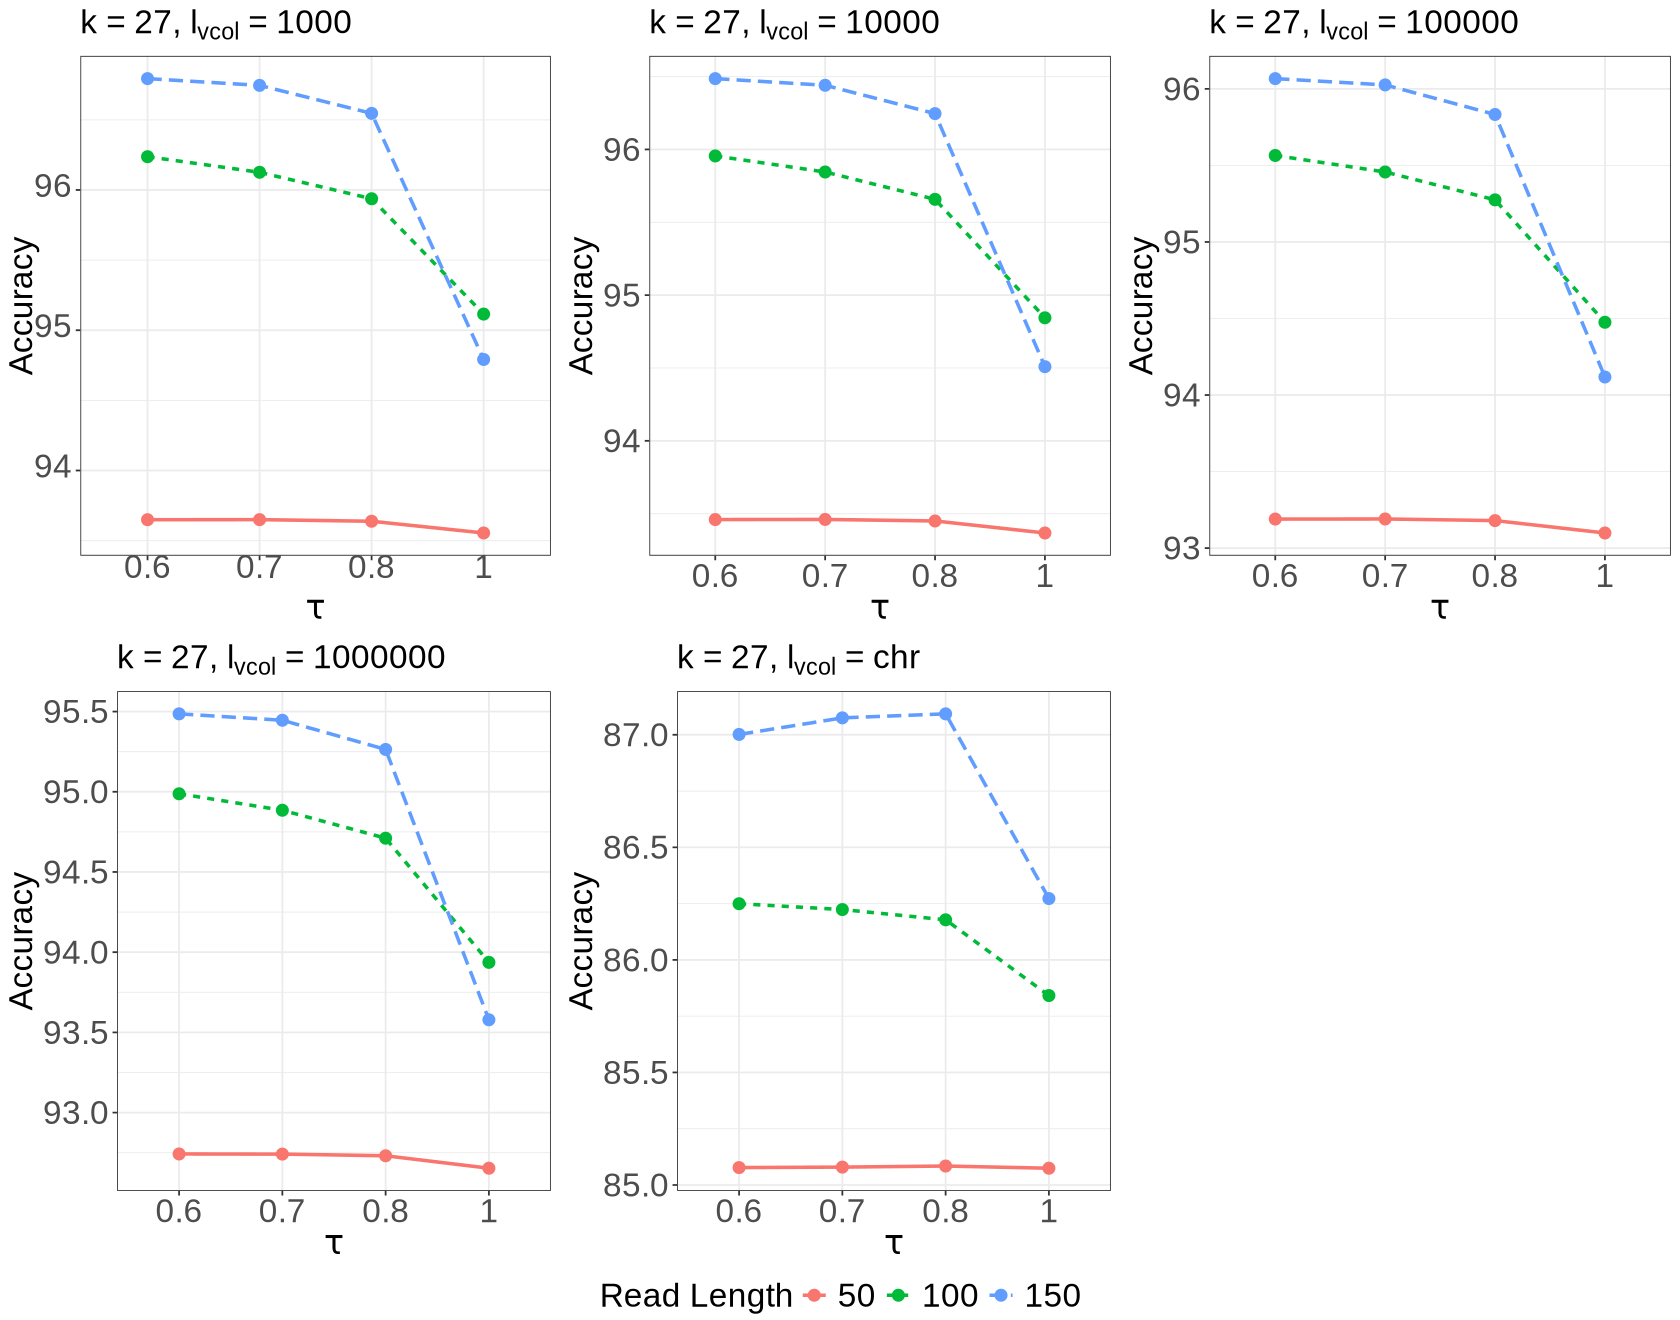

In [52]:
ggarrange(plotlist = pKBin[[3]], common.legend = TRUE, legend = "bottom")

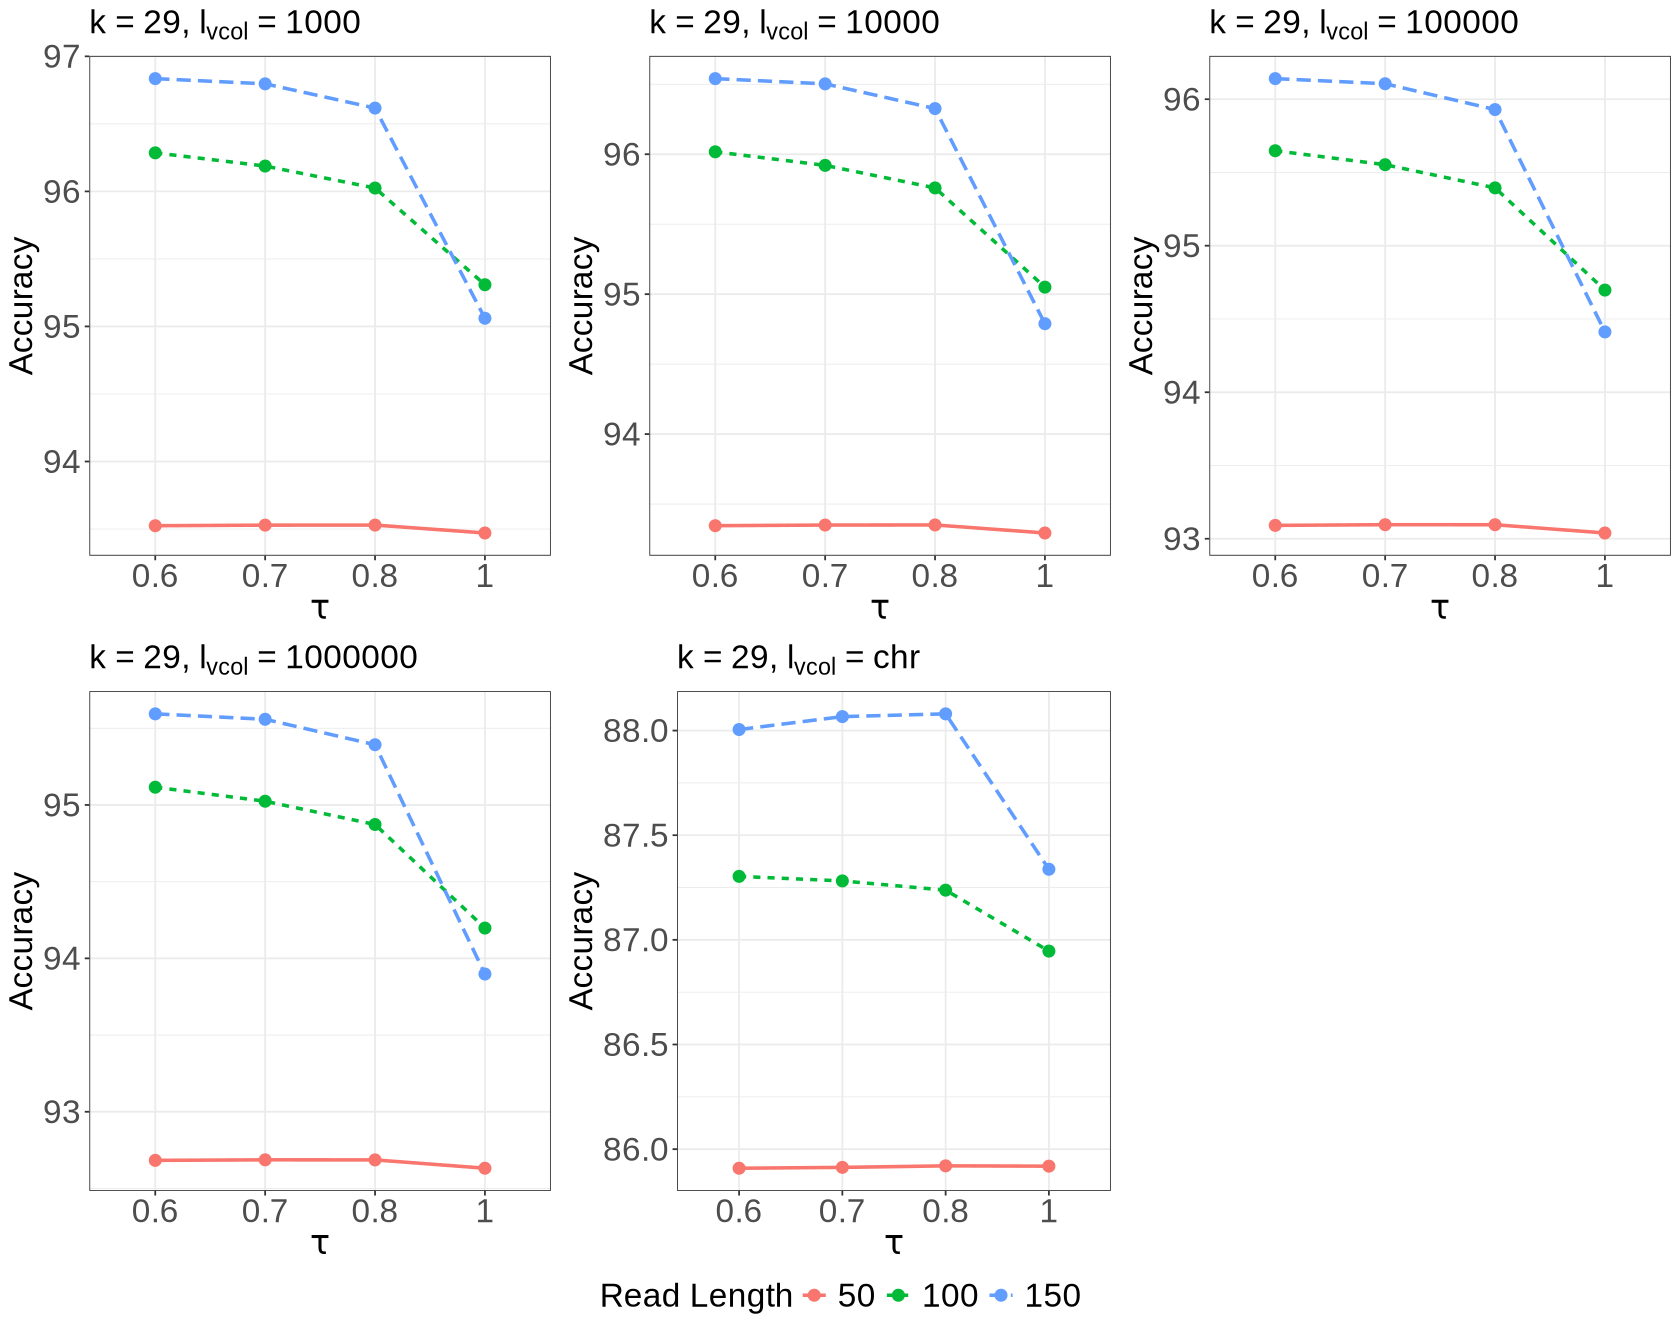

In [53]:
ggarrange(plotlist = pKBin[[4]], common.legend = TRUE, legend = "bottom")

#### Varying Threshold and Bin Size

In [59]:
size <- 20
pThrBin <- vector(mode="list", length(thr))
names(pThrBin) <- paste("thr",thr,sep="")
for(i in seq_along(thr)) {
    pThrBin[[i]] <- vector(mode="list", length(bins))
    names(pThrBin[[i]]) <- paste("bin", bins, sep="")
    for(j in seq_along(bins)) {
        dTemp <- dfL %>% 
            filter(threshold==thr[i], bin_size==paste0("bin",bins[j]))
        if (j==5) {
           dTemp <- dfL %>%
            filter(threshold==thr[i], bin_size=="binchr")
         }
        bb <- ifelse(j<=4, bins[j], "chr")
        pThrBin[[i]][[j]] <- dTemp %>%
            ggplot(aes(x=k,y=accuracy, group=read_length)) + 
            geom_point(size=3,aes(color=factor(read_length))) +
            geom_line(size=1, aes(color=factor(read_length), linetype=factor(read_length))) +
            theme_bw() +
            labs(title = TeX(paste0("$\\tau$ = ", thr[i], ", $l_{vcol}$ = ", bb)), 
                    x = "k", y = "Accuracy", color = "Read Length", linetype = "Read Length") +
              theme(
                plot.title = element_text(size = size),           # Title font size
                axis.title.x = element_text(size = size),         # X-axis label font size
                axis.title.y = element_text(size = size),         # Y-axis label font size
                axis.text = element_text(size = size),            # Tick mark font size
                legend.title = element_text(size = size),         # Legend title font size
                legend.text = element_text(size = size)           # Legend text font size
              )
    }
}        

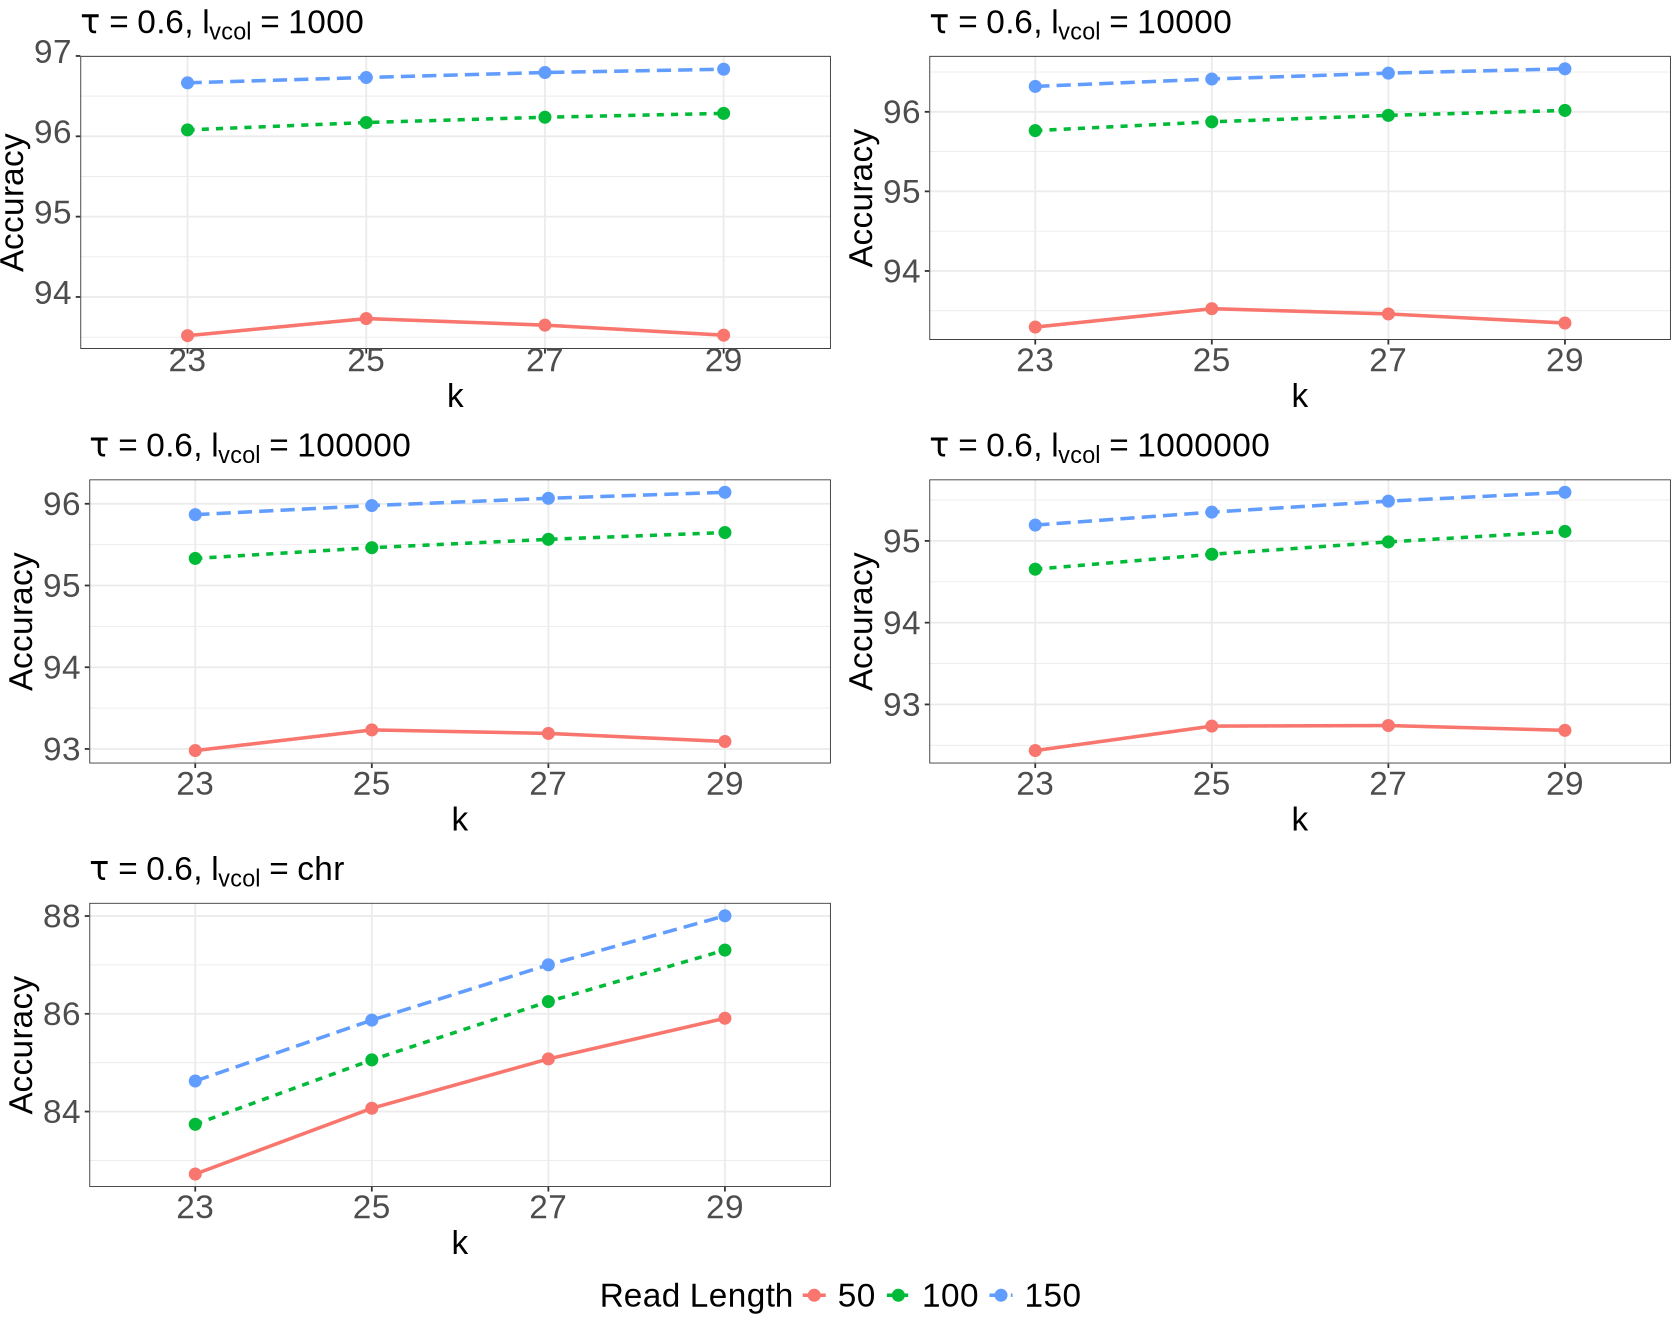

In [60]:
ggarrange(plotlist = pThrBin[[1]], common.legend = TRUE, legend = "bottom", nrow=3,ncol = 2)

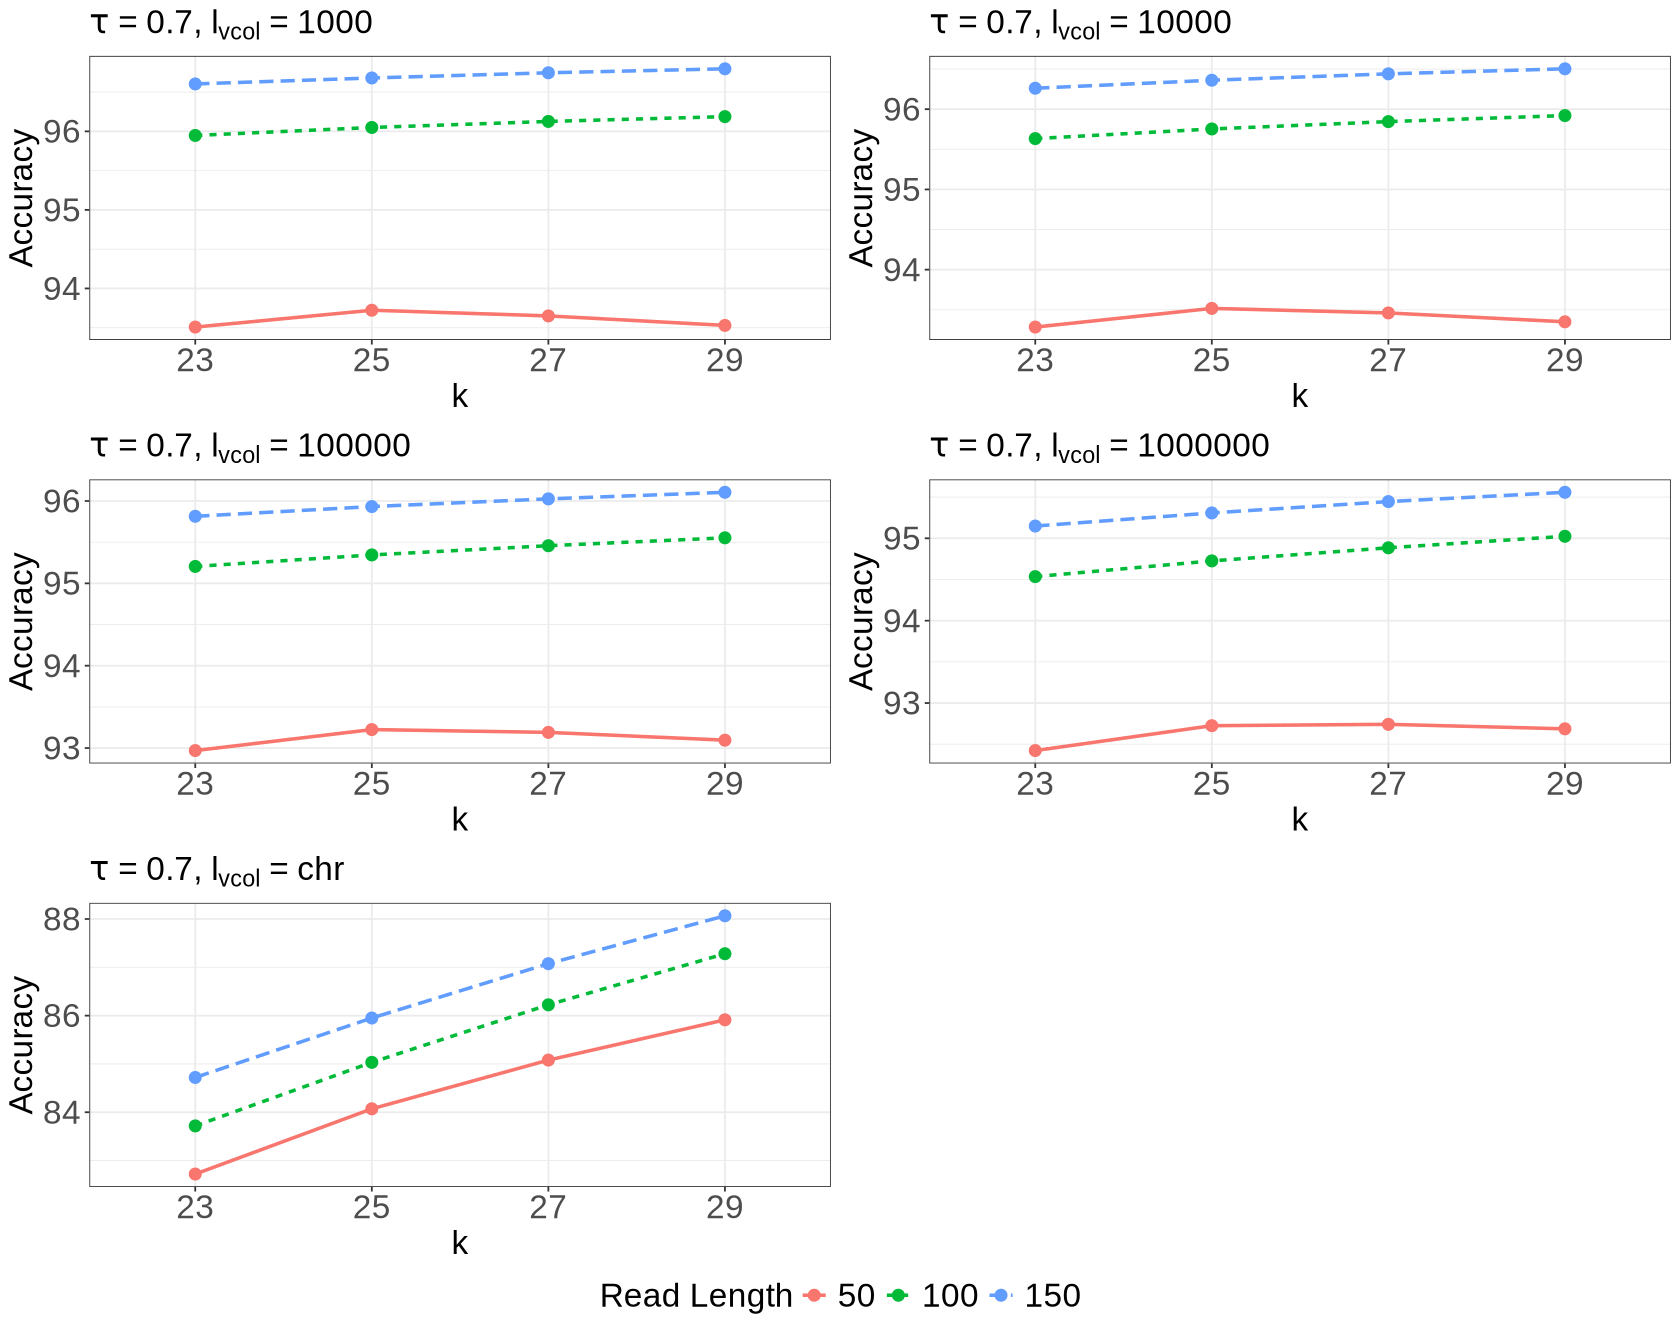

In [61]:
ggarrange(plotlist = pThrBin[[2]], common.legend = TRUE, legend = "bottom", nrow=3,ncol = 2)

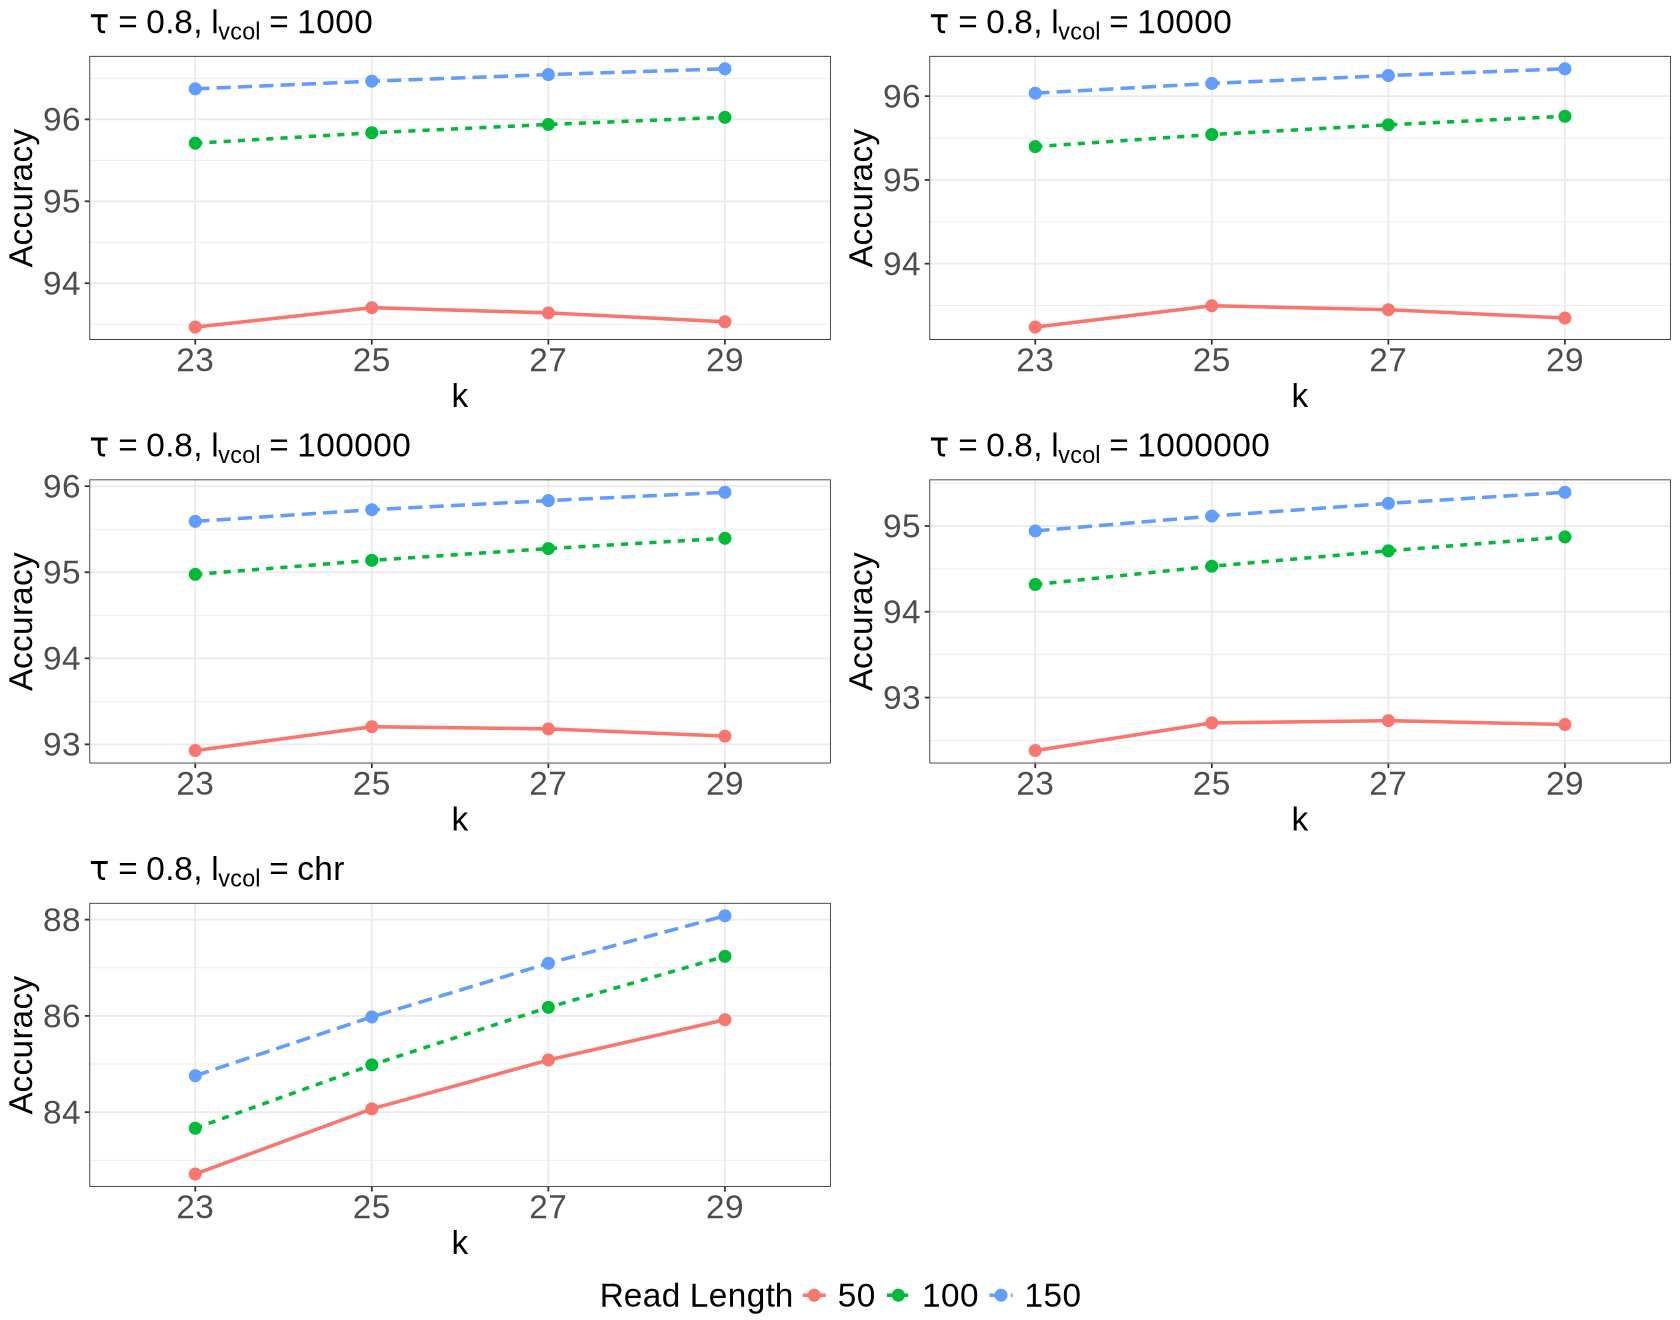

In [62]:
ggarrange(plotlist = pThrBin[[3]], common.legend = TRUE, legend = "bottom", nrow=3,ncol = 2)

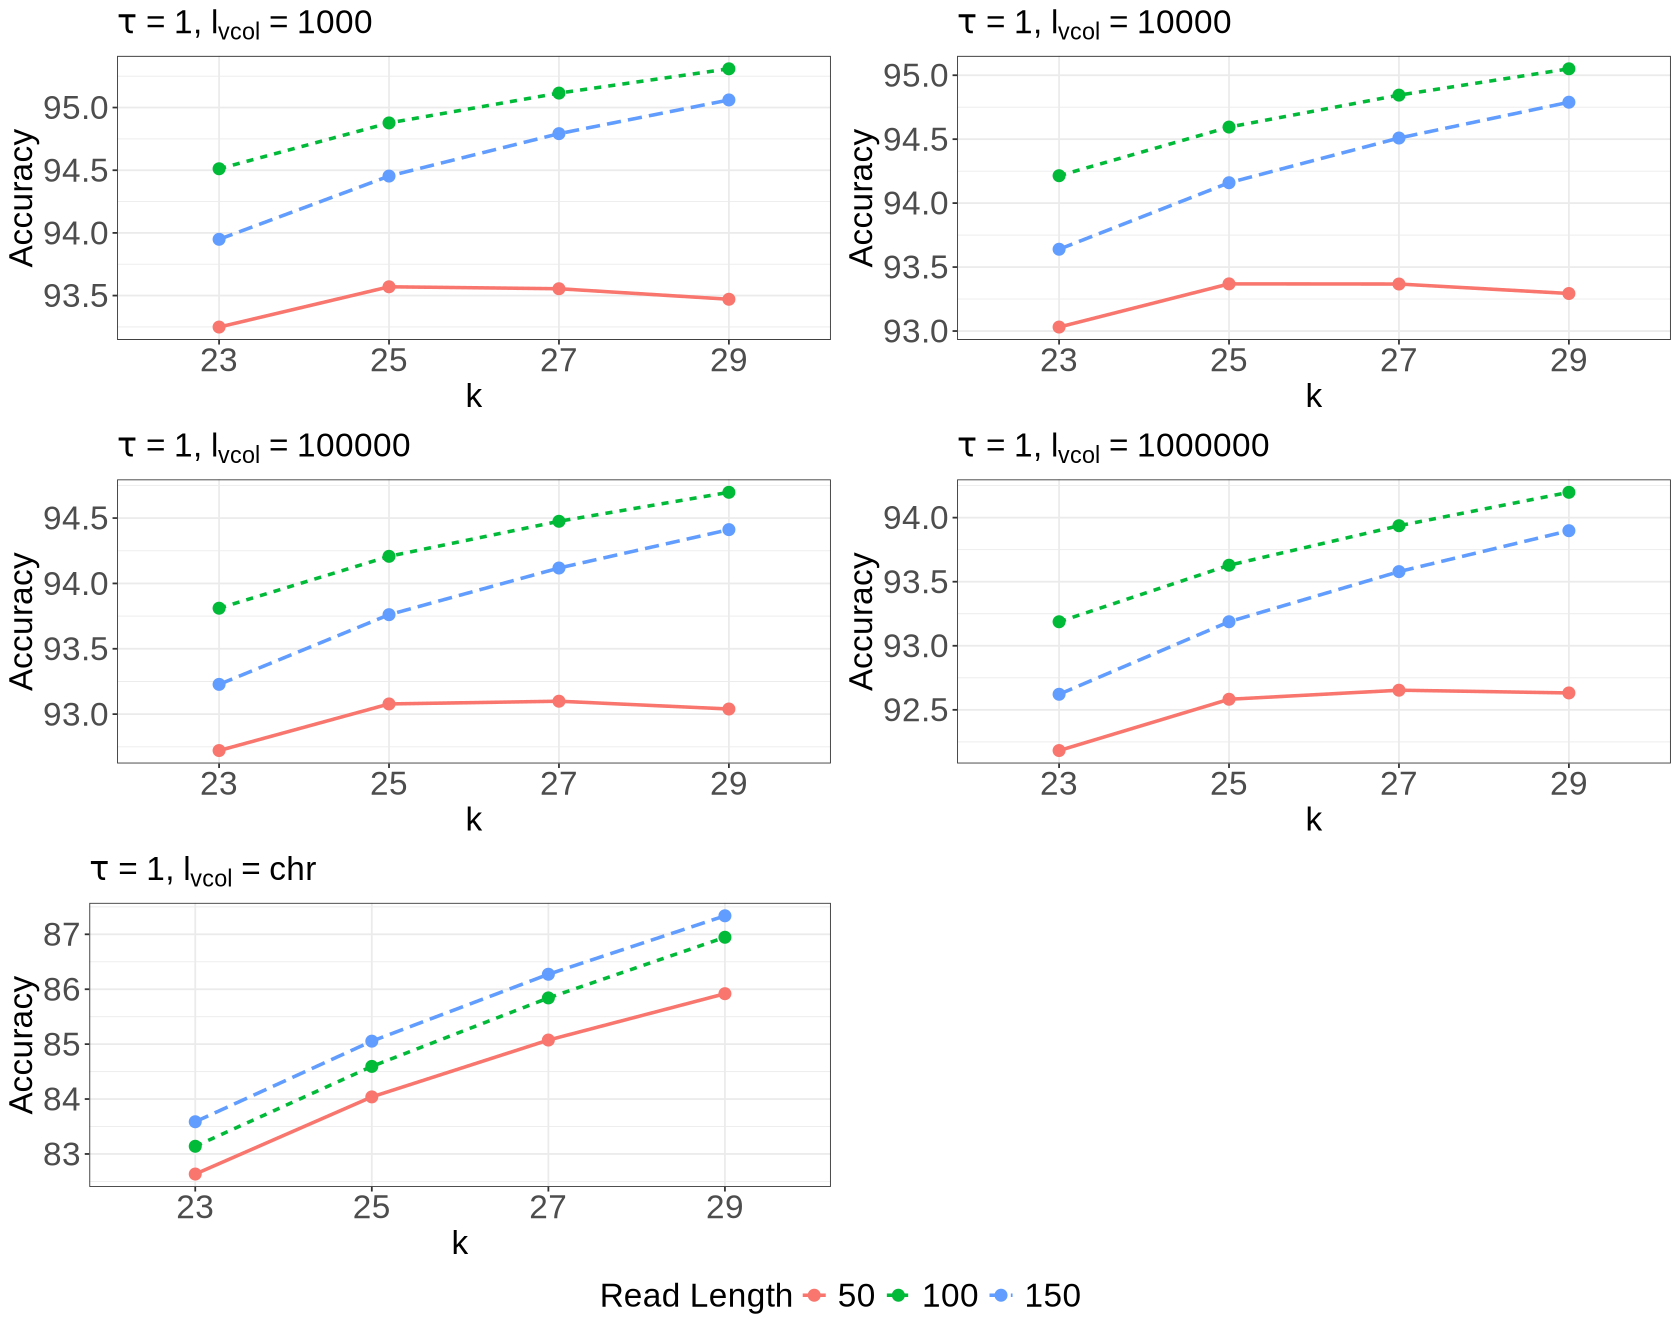

In [63]:
ggarrange(plotlist = pThrBin[[4]], common.legend = TRUE, legend = "bottom", nrow=3,ncol = 2)

#### Summarized piscem plot

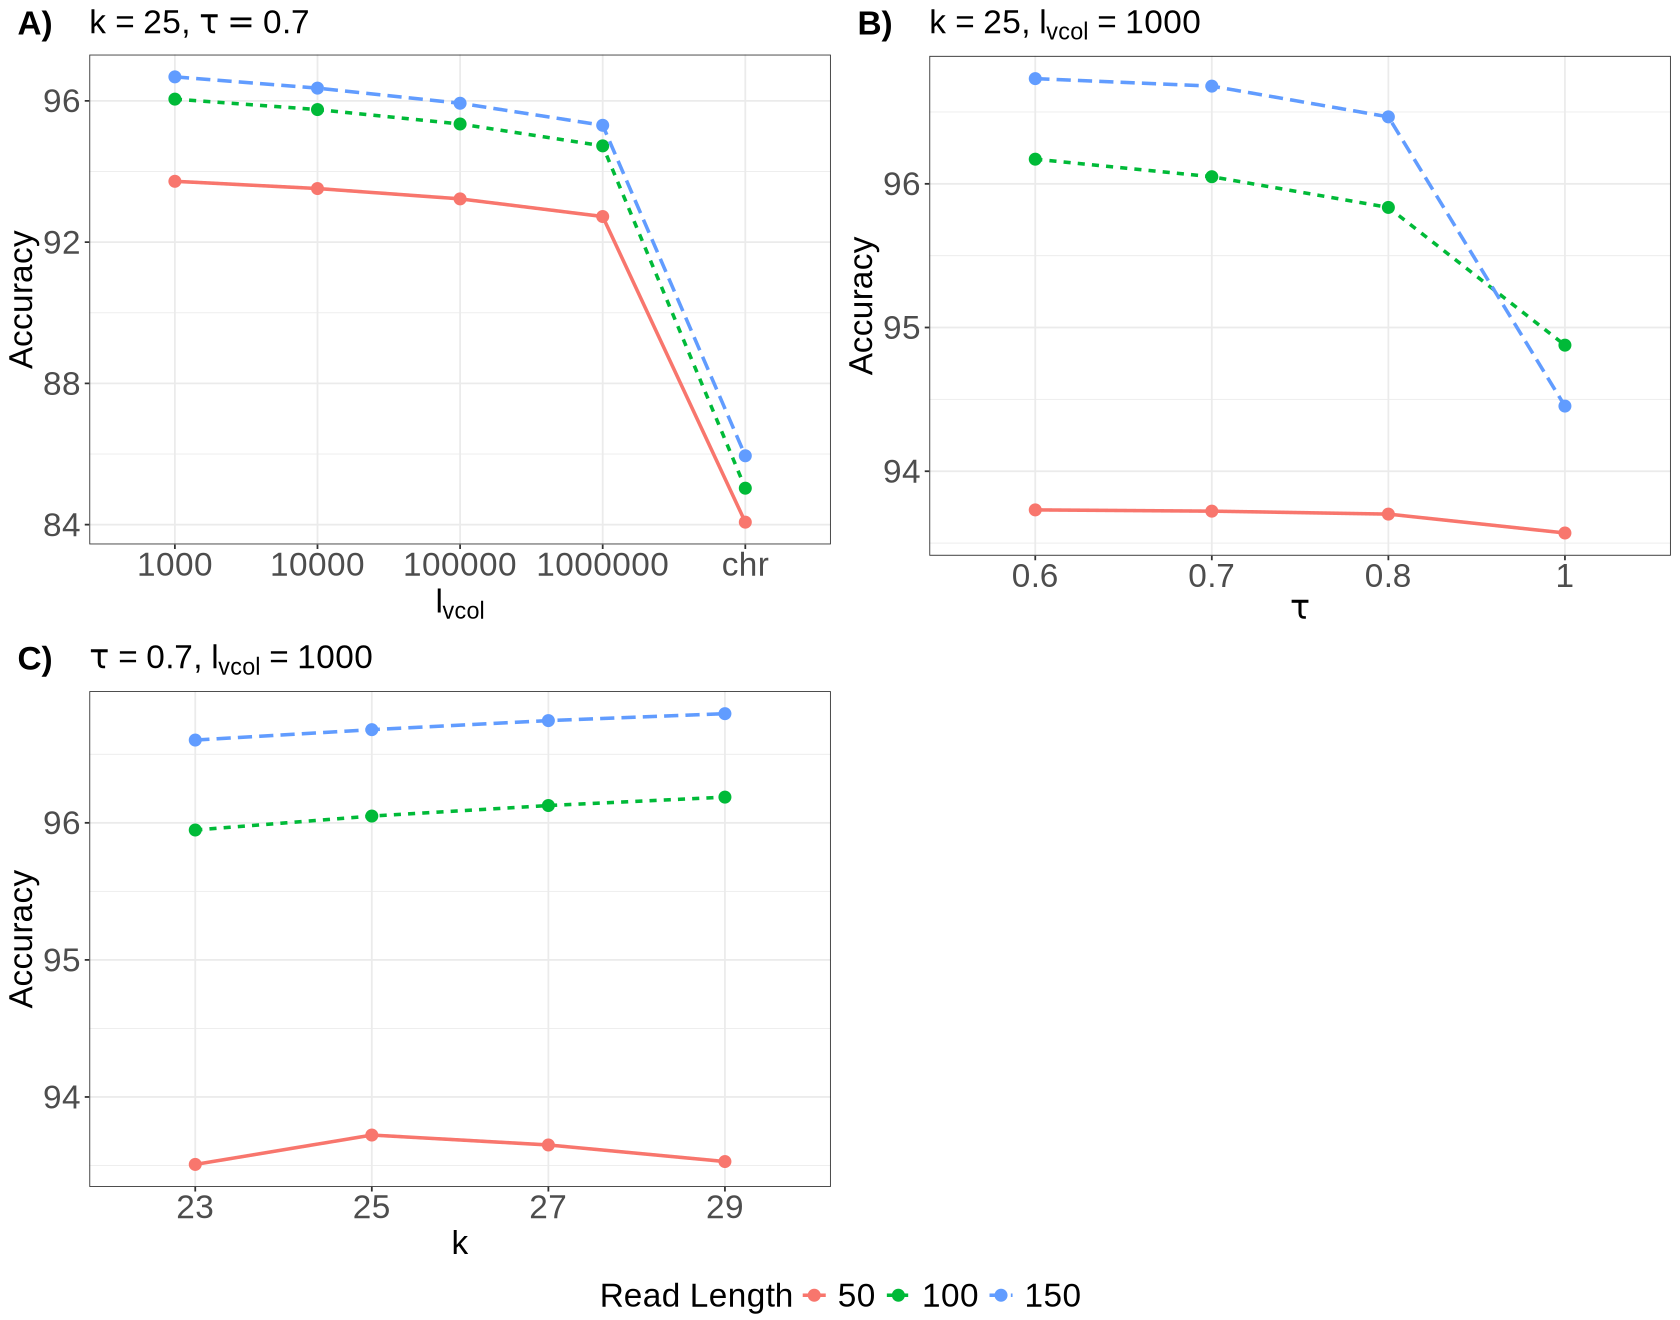

In [64]:
ggarrange(pKThr[[2]][[2]], pKBin[[2]][[1]], pThrBin[[2]][[1]], common.legend = T, 
          legend = "bottom", labels = c("A)", "B)", "C)"), font.label = list(size=size))

In [82]:
dfL %>% filter(k=="25", threshold=="0.7")

read_length,threshold,k,bin_size,accuracy
<dbl>,<chr>,<chr>,<chr>,<dbl>
50,0.7,25,bin1000,93.7222
50,0.7,25,bin10000,93.5172
50,0.7,25,bin100000,93.2245
50,0.7,25,bin1000000,92.7247
50,0.7,25,binchr,84.0709
100,0.7,25,bin1000,96.0494
100,0.7,25,bin10000,95.7534
100,0.7,25,bin100000,95.3451
100,0.7,25,bin1000000,94.7256


In [83]:
dfL %>% filter(k=="25", bin_size=="bin1000")

read_length,threshold,k,bin_size,accuracy
<dbl>,<chr>,<chr>,<chr>,<dbl>
50,0.6,25,bin1000,93.7310
50,0.7,25,bin1000,93.7222
50,0.8,25,bin1000,93.7016
50,1,25,bin1000,93.5702
100,0.6,25,bin1000,96.1714
100,0.7,25,bin1000,96.0494
100,0.8,25,bin1000,95.8357
100,1,25,bin1000,94.8772
150,0.6,25,bin1000,96.7320


In [84]:
dfL %>% filter(threshold=="0.7", bin_size=="bin1000")

read_length,threshold,k,bin_size,accuracy
<dbl>,<chr>,<chr>,<chr>,<dbl>
50,0.7,23,bin1000,93.5080
50,0.7,25,bin1000,93.7222
50,0.7,27,bin1000,93.6498
50,0.7,29,bin1000,93.5289
100,0.7,23,bin1000,95.9477
100,0.7,25,bin1000,96.0494
100,0.7,27,bin1000,96.1262
100,0.7,29,bin1000,96.1876
150,0.7,23,bin1000,96.6039


In [274]:
dfResults[6+1:3,3] <- dfL %>% filter(k==25, threshold==0.7, bin_size=="bin1000") %>%
    select(accuracy) %>% unlist

In [279]:
dfResults %>% 

read_length,method,accuracy
<dbl>,<chr>,<dbl>
50,Bowtie2,95.7141
100,Bowtie2,97.1578
150,Bowtie2,97.6514
50,Chromap,95.4808
100,Chromap,97.1099
150,Chromap,97.6076
50,Piscem,93.7222
100,Piscem,96.0494
150,Piscem,96.6797


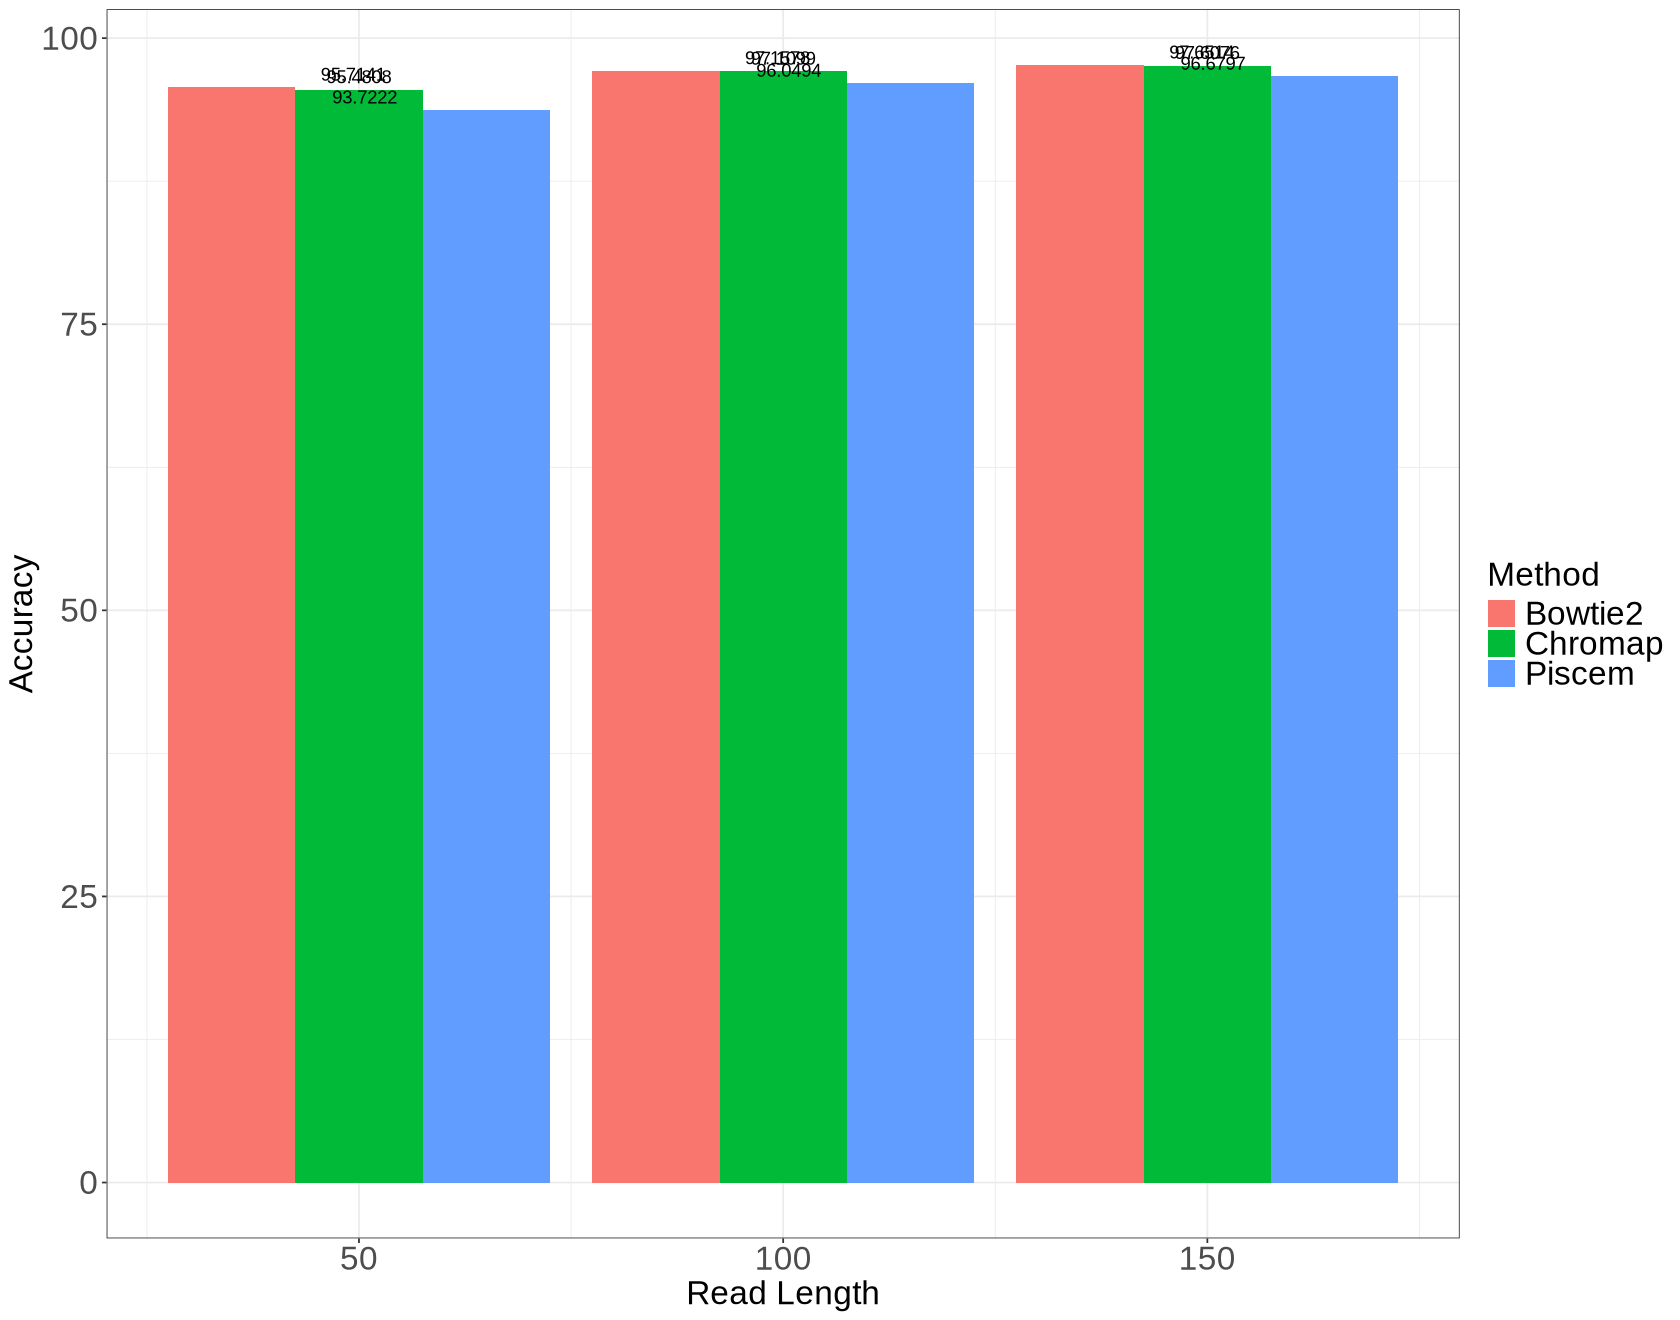

In [294]:
ggplot(dfResults, aes(x=read_length, y=accuracy, fill=factor(method))) +
    geom_bar(stat = "identity", position = "dodge") + theme_bw() +
     labs(x = "Read Length", y = "Accuracy", fill = "Method") +
      theme(
        plot.title = element_text(size = size),           # Title font size
        axis.title.x = element_text(size = size),         # X-axis label font size
        axis.title.y = element_text(size = size),         # Y-axis label font size
        axis.text = element_text(size = size),            # Tick mark font size
        legend.title = element_text(size = size),         # Legend title font size
        legend.text = element_text(size = size)           # Legend text font size
      )